In [1]:
import pandas as pd
import numpy as np

import os

from sklearn import linear_model, cross_validation, grid_search, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import  cross_val_score

import xgboost
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
AllState_train = pd.read_csv('/home/shenbaga/data-files/AllState_Insurance/train.csv')

In [4]:
AllState_train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
AllState_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [6]:
#using code from: https://www.kaggle.com/guyko81/allstate-claims-severity/just-an-easy-solution/notebook

In [7]:
#create features list
features = [x for x in AllState_train.columns if x not in ['id', 'loss']]

In [8]:
features

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18',
 'cat19',
 'cat20',
 'cat21',
 'cat22',
 'cat23',
 'cat24',
 'cat25',
 'cat26',
 'cat27',
 'cat28',
 'cat29',
 'cat30',
 'cat31',
 'cat32',
 'cat33',
 'cat34',
 'cat35',
 'cat36',
 'cat37',
 'cat38',
 'cat39',
 'cat40',
 'cat41',
 'cat42',
 'cat43',
 'cat44',
 'cat45',
 'cat46',
 'cat47',
 'cat48',
 'cat49',
 'cat50',
 'cat51',
 'cat52',
 'cat53',
 'cat54',
 'cat55',
 'cat56',
 'cat57',
 'cat58',
 'cat59',
 'cat60',
 'cat61',
 'cat62',
 'cat63',
 'cat64',
 'cat65',
 'cat66',
 'cat67',
 'cat68',
 'cat69',
 'cat70',
 'cat71',
 'cat72',
 'cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101

In [8]:
#categorical and numeric features separately
cat_features = [x for x in AllState_train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in AllState_train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

In [9]:
print len(features), len(cat_features), len(num_features)

130 116 14


In [11]:
#so cat.codes gets your numeric values for a categorical column
#let's do this for both the train and test dfs

In [12]:
AllState_test = pd.read_csv('/home/shenbaga/data-files/AllState_Insurance/test.csv')

In [13]:
# get the number of rows in train and test. we need this to split train and test from the unioned set

ntrain = AllState_train.shape[0]
ntest = AllState_test.shape[0]

#create a unioned set to perform the encoding operation

train_test = pd.concat((AllState_train[features], AllState_test[features])).reset_index(drop=True)

#encoding operation as seen in the example above
for c in range(len(cat_features)):
    train_test[cat_features[c]] = train_test[cat_features[c]].astype('category').cat.codes


#now we would have the categorical columns having numeric values in stead of their original string vals

#get the train and test back from the unioned set
train_x = train_test.iloc[:ntrain,:]
test_x = train_test.iloc[ntrain:,:]

In [14]:
#the code has used logloss.. using it
from scipy.stats import norm, lognorm

AllState_train['log_loss'] = np.log(AllState_train['loss'])

In [15]:
import xgboost as xgb

In [25]:
# Create our DMatrix to make XGBoost more efficient
xgdmat = xgb.DMatrix(train_x, AllState_train['log_loss'])

In [26]:
xgdmat

In [28]:
#build xgb tree
params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3} 

# Grid Search CV optimized settings
num_rounds = 1000
bst = xgb.train(params, xgdmat, num_boost_round = num_rounds)

In [29]:
bst

In [31]:
bst.get_fscore()

{'cat1': 536,
 'cat10': 119,
 'cat100': 2870,
 'cat101': 1124,
 'cat102': 226,
 'cat103': 836,
 'cat104': 263,
 'cat105': 449,
 'cat106': 338,
 'cat107': 507,
 'cat108': 580,
 'cat109': 280,
 'cat11': 143,
 'cat110': 721,
 'cat111': 893,
 'cat112': 1193,
 'cat113': 967,
 'cat114': 1156,
 'cat115': 410,
 'cat116': 780,
 'cat12': 388,
 'cat13': 144,
 'cat14': 42,
 'cat16': 30,
 'cat17': 40,
 'cat18': 28,
 'cat19': 114,
 'cat2': 586,
 'cat20': 2,
 'cat21': 51,
 'cat22': 12,
 'cat23': 202,
 'cat24': 46,
 'cat25': 266,
 'cat26': 327,
 'cat27': 375,
 'cat28': 57,
 'cat29': 78,
 'cat3': 160,
 'cat30': 42,
 'cat31': 205,
 'cat32': 83,
 'cat33': 19,
 'cat34': 12,
 'cat35': 3,
 'cat36': 218,
 'cat37': 359,
 'cat38': 314,
 'cat39': 188,
 'cat4': 451,
 'cat40': 96,
 'cat41': 90,
 'cat42': 83,
 'cat43': 68,
 'cat44': 378,
 'cat45': 62,
 'cat46': 15,
 'cat47': 14,
 'cat48': 7,
 'cat49': 230,
 'cat5': 501,
 'cat50': 289,
 'cat51': 116,
 'cat52': 185,
 'cat53': 518,
 'cat54': 85,
 'cat55': 7,
 'cat56'

,feature,fscore
0,cat62,0.000018
1,cat20,0.000037
2,cat35,0.000055
3,cat68,0.000073
4,cat48,0.000128
5,cat55,0.000128
6,cat58,0.000183
7,cat34,0.000219
8,cat22,0.000219
9,cat63,0.000238


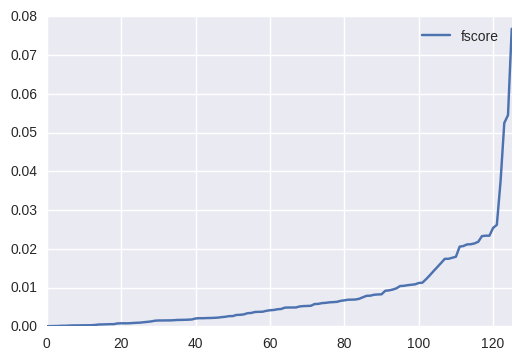

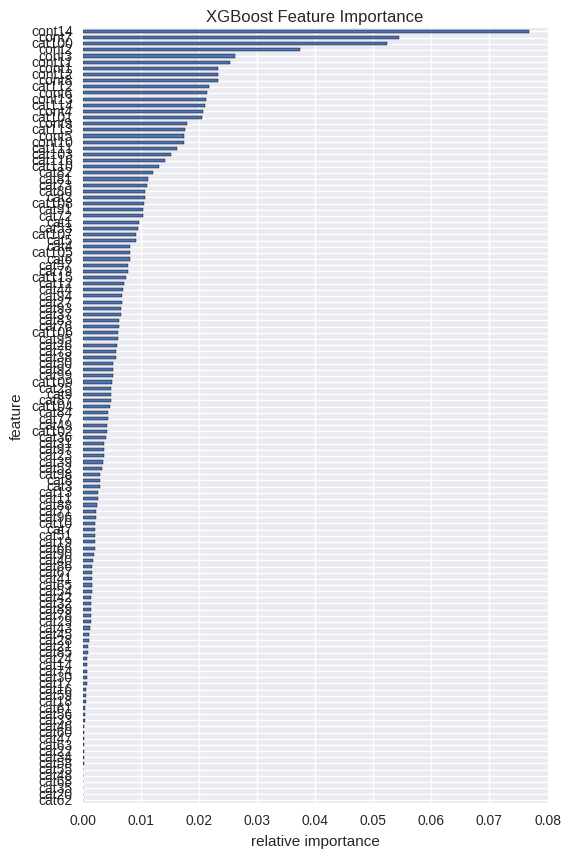

In [32]:
import operator

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    
ceate_feature_map(features)

importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

df

In [34]:
test_xgb = xgb.DMatrix(test_x)
submission = pd.read_csv("/home/shenbaga/data-files/AllState_Insurance/sample_submission.csv")
submission.iloc[:, 1] = np.exp(bst.predict(test_xgb))
submission.to_csv('xgb_starter.sub.csv', index=None)

In [35]:
#the above submission has MAE of 1139.83586 and a rank of 1541 !!
#now let's try to do XGB in the other way

In [16]:
from xgboost import XGBClassifier

In [19]:
gsearch1 = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, min_child_weight = 5)

In [ ]:
gsearch1.fit(train_x, AllState_train['log_loss'])

In [ ]:
#started at 4:00 PM